<a href="https://colab.research.google.com/github/kishore-n-george/tabular-llm-comparison/blob/main/Dataset_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 %% [markdown]
# Dry Bean Dataset - Data Cleansing & Preparation & XGB Classification
# **Author:** Kishore George
# **Date:** DD-MM-YYYY  
# **Dataset Source:** Koklu, M. and Ozkan, I.A. (2020)

In [1]:
#python3 -m venv tabular
#!pip install jupyter numpy pandas scikit-learn xgboost torch transformers shap scikit-learn seaborn matplotlib ucimlrepo xgboost tabpfn rtdl torch lime folium eli5
# torchvision torchaudio
# ft_transformer

#linear algebra
import numpy as np 
import math

#data tools
from copy import copy
import pandas as pd
from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from IPython.display import Image

#plots
import seaborn as sns
import matplotlib.pyplot as plt

#models
from tabpfn import TabPFNClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#model interpretation modules
import lime
import lime.lime_tabular
import shap
# import eli5

#metrics
from sklearn.metrics import mean_squared_error, r2_score, precision_score, classification_report, recall_score, mean_squared_error, accuracy_score, f1_score, roc_auc_score, confusion_matrix

#awesome interactive map library
import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster

#statistics
from scipy import stats

#ucimlrepo
from ucimlrepo import fetch_ucirepo, dotdict


import time

%matplotlib inline
sns.set_style("whitegrid")

/home/ec2-user/tabular/lib/python3.11/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:

# %% [markdown]
# ## 2. Load Dataset
drybean_original = fetch_ucirepo(id=602)
drybean = drybean_original.data.original
print("Dataset shape:", drybean.shape)
drybean.head()



Dataset shape: (13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [3]:
# %% [markdown]
# ## 3. Initial Data Exploration
# Check basic stats and missing values
print("\n=== Basic Info ===")
print(drybean.info())

print("\n=== Missing Values ===")
print(drybean.isnull().sum())

print("\n=== Class Distribution ===")
print(drybean['Class'].value_counts())





=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRatio      13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  Roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  objec


Number of duplicates before removal: 68
Number of duplicates after removal: 0


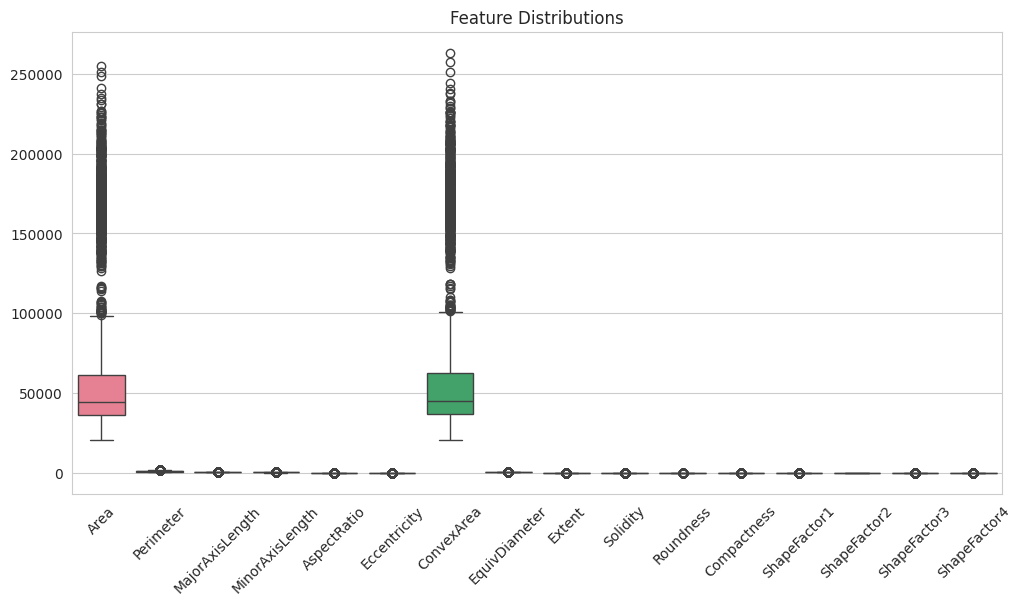

In [4]:
# %% [markdown]
# ## 4. Data Cleansing

# %% [markdown]
# ### 4.1 Remove Duplicates
print("\nNumber of duplicates before removal:", drybean.duplicated().sum())
drybean = drybean.drop_duplicates()
print("Number of duplicates after removal:", drybean.duplicated().sum())

# %% [markdown]
# ### 4.2 Handle Missing Values (if any)
# No missing values in original dataset, but added for robustness
if drybean.isnull().sum().sum() > 0:
    # Option 1: Drop rows with missing values
    drybean = drybean.dropna()
    
    # Option 2: Impute numerical features (example)
    # from sklearn.impute import SimpleImputer
    # num_cols = drybean.select_dtypes(include=np.number).columns
    # imputer = SimpleImputer(strategy='median')
    # drybean[num_cols] = imputer.fit_transform(drybean[num_cols])

# %% [markdown]
# ### 4.3 Handle Outliers
# Visualize numerical features
plt.figure(figsize=(12, 6))
sns.boxplot(data=drybean.select_dtypes(include=np.number))
plt.xticks(rotation=45)
plt.title("Feature Distributions")
plt.show()



/tmp/ipykernel_5978/190866093.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drybean['Class'] = le.fit_transform(drybean['Class'])



Encoded Classes: ['BARBUNYA' 'BOMBAY' 'CALI' 'DERMASON' 'HOROZ' 'SEKER' 'SIRA']

Train shape: (10834, 16)
Test shape: (2709, 16)


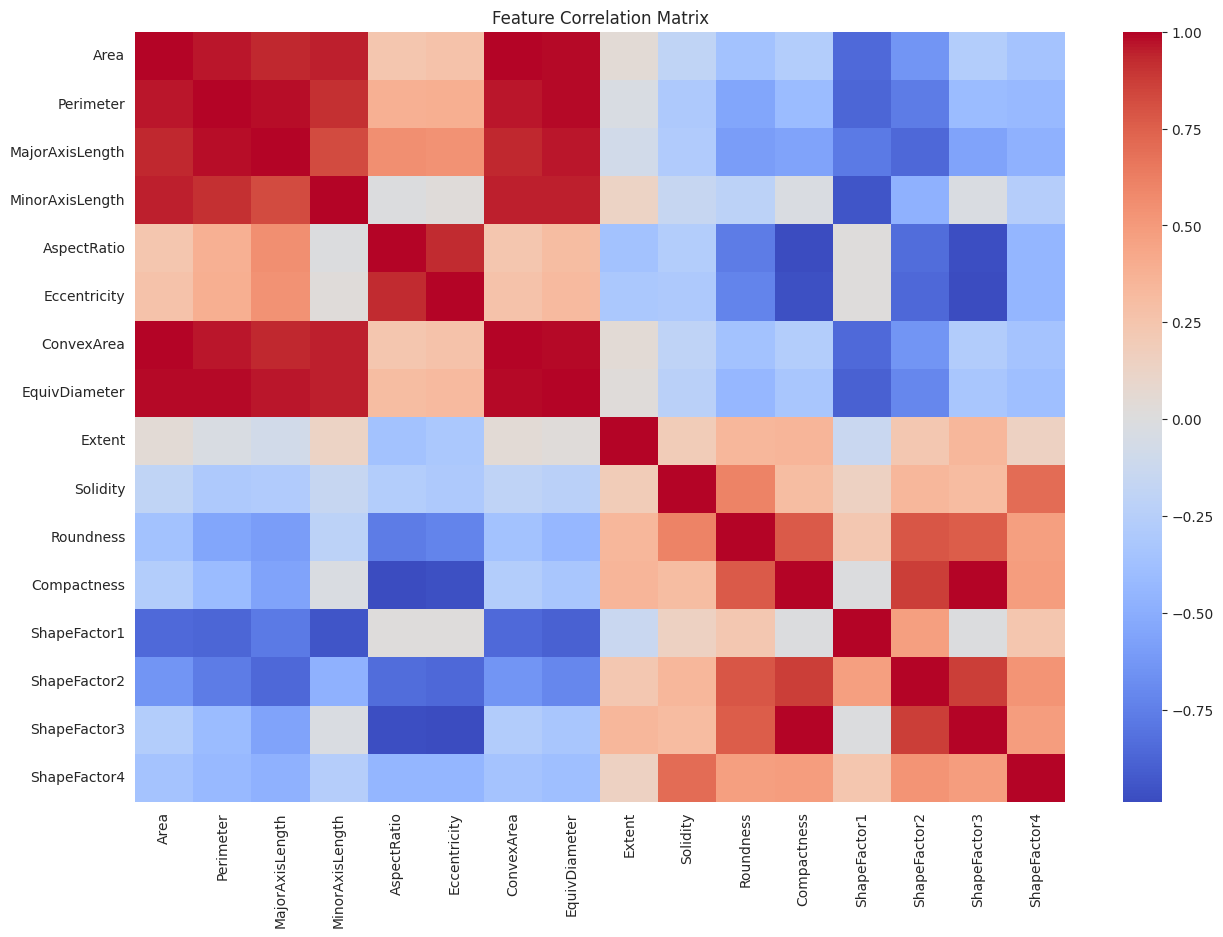

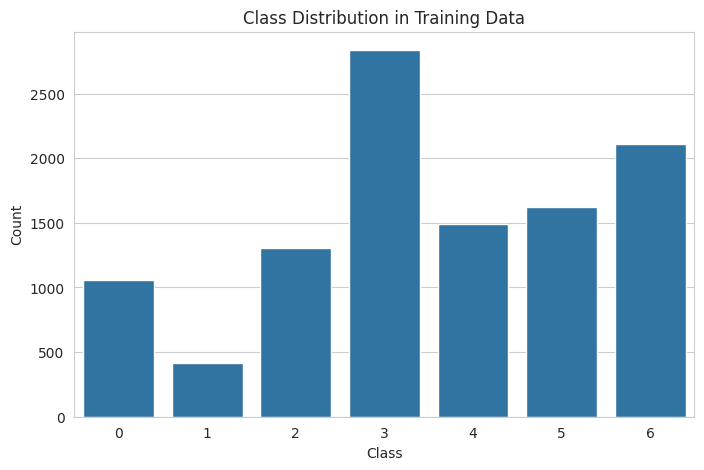

In [5]:
# Option: Remove outliers using IQR (example for one column)
# Q1 = drybean['Area'].quantile(0.25)
# Q3 = drybean['Area'].quantile(0.75)
# IQR = Q3 - Q1
# drybean = drybean[~((drybean['Area'] < (Q1 - 1.5 * IQR)) | (drybean['Area'] > (Q3 + 1.5 * IQR)))]

# %% [markdown]
# ## 5. Data Preparation

# %% [markdown]
# ### 5.1 Encode Categorical Target
le = LabelEncoder()
drybean['Class'] = le.fit_transform(drybean['Class'])
print("\nEncoded Classes:", le.classes_)

# %% [markdown]
# ### 5.2 Feature-Target Split
X_bean = drybean.drop('Class', axis=1)
y_bean = drybean['Class']

# %% [markdown]
# ### 5.3 Train-Test Split
X_train_bean, X_test_bean, y_train_bean, y_test_bean = train_test_split(
    X_bean, y_bean, 
    test_size=0.2, 
    stratify=y_bean,  # Preserve class distribution
    random_state=42
)

print("\nTrain shape:", X_train_bean.shape)
print("Test shape:", X_test_bean.shape)

# Save unscaled X_test before transformation
X_test_unscaled = X_test_bean.copy()

# %% [markdown]
# ### 5.4 Feature Scaling (Optional for tree-based models)
# Only needed for models like FT-Transformer or neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bean)
X_test_scaled = scaler.transform(X_test_bean)

# Convert back to DataFrame for interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_bean.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_bean.columns)


# %% [markdown]
# ## 7. Exploratory Data Analysis (Optional)

# %% [markdown]
# ### 7.1 Correlation Matrix
plt.figure(figsize=(15, 10))
sns.heatmap(X_train_bean.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# %% [markdown]
# ### 7.2 Class Distribution Visualization
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_bean)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

XGB Classification

In [7]:

# xgb_clf_bean = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_bean.unique()))
xgb_clf_bean = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
start_time = time.time()
xgb_clf_bean.fit(X_train_bean, y_train_bean)
xgb_bean_train_time = time.time() - start_time

# Predictions for XGBoost
start_time = time.time()
xgb_y_pred_bean = xgb_clf_bean.predict(X_test_bean)
xgb_bean_inference_time = time.time() - start_time

# metrics

print(f"XGBoost Training time: {xgb_bean_train_time:.4f}")
print(f"XGBoost Inference time: {xgb_bean_inference_time:.4f}")

accuracy_bean = accuracy_score(y_test_bean, xgb_y_pred_bean)
print(f'Dry Bean Accuracy: {accuracy_bean}')


/home/ec2-user/tabular/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:53:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Dry Bean Accuracy: 0.9198966408268734


              precision    recall  f1-score   support

           0       0.92      0.89      0.91       265
           1       1.00      1.00      1.00       104
           2       0.92      0.93      0.93       326
           3       0.91      0.92      0.92       709
           4       0.96      0.94      0.95       372
           5       0.94      0.95      0.95       406
           6       0.87      0.87      0.87       527

    accuracy                           0.92      2709
   macro avg       0.93      0.93      0.93      2709
weighted avg       0.92      0.92      0.92      2709



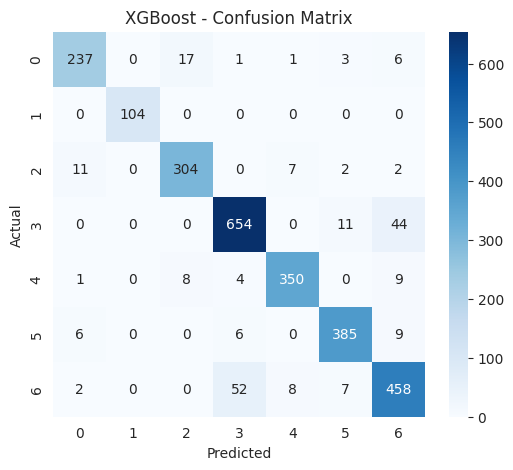

In [8]:
print(classification_report(y_test_bean, xgb_y_pred_bean))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_bean, xgb_y_pred_bean), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [60]:
# Summary plot
# Model Interpretability with SHAP
explainer = shap.Explainer(xgb_clf_bean,X_test_bean)
shap_values = explainer.shap_values(X_test_bean)

100%|===================| 18941/18963 [06:20<00:00]        

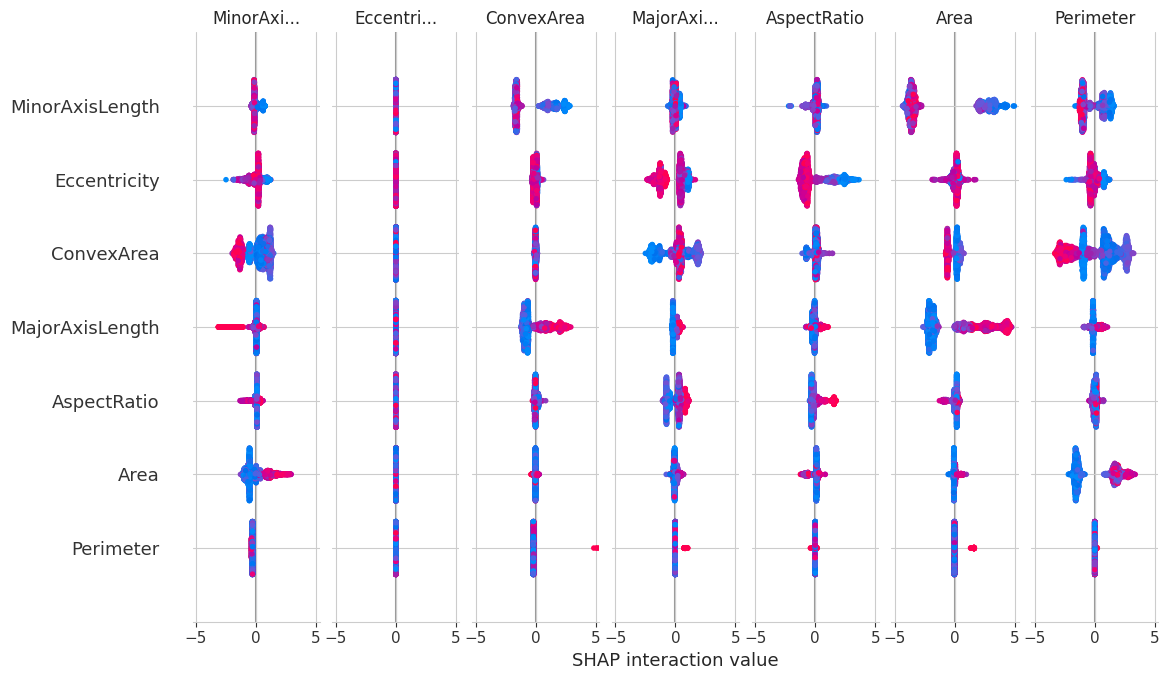

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 7 and the array at index 1 has size 50

In [59]:
shap.summary_plot(shap_values, X_test_unscaled)
# # Feature Importance Plot
# plt.figure(figsize=(10, 6))
# shap.bar_plot(shap_values, max_display=10)
# plt.title("Feature Importance (SHAP)")
# plt.show()

# SHAP Dependence Plot for Top Features
top_feature = X_test_unscaled.columns[np.argmax(np.abs(shap_values).mean(axis=0))]
shap.dependence_plot(top_feature, shap_values, X_test_unscaled)

In [31]:
#TabPFN needs unscaled data
unscaled = drybean_original.data.original

le = LabelEncoder()

unscaled['Class'] = le.fit_transform(unscaled['Class'])

print("\nEncoded Classes:", le.classes_)

X_bean_pfn = unscaled.drop('Class', axis=1)
y_bean_pfn = unscaled['Class']


# Identify categorical and numerical columns
categorical_cols = X_bean_pfn.select_dtypes(include=['object']).columns.tolist()

# One-hot encoding for categorical features
X_bean_pfn = pd.get_dummies(X_bean_pfn, columns=categorical_cols, drop_first=True)

# Split the data
X_train_bean_pfn, X_test_bean_pfn, y_train_bean_pfn, y_test_bean_pfn = train_test_split(X_bean_pfn, y_bean_pfn, test_size=0.2, random_state=42)


Encoded Classes: [0 1 2 3 4 5 6]


In [32]:
import torch
torch.cuda.empty_cache()

batch_size = 16 

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# Initialize and train TabPFN
bean_pfn_model = TabPFNClassifier(device='cuda', N_ensemble_configurations=32)  # Use 'cuda' if GPU available
#start_time = time.time()
#bean_pfn_model.fit(X_train_bean_pfn.values, y_train_bean_pfn.values, overwrite_warning=True)
#pfn_train_time = time.time() - start_time

# Predictions for TabPFN
#start_time = time.time()
#pfn_y_pred_bean = bean_pfn_model.predict(X_test_bean_pfn.values)
#pfn_inference_time = time.time() - start_time

# Select a few samples per class
X_train_bean_pfn['Class']=y_train_bean_pfn
few_shot_samples = 140  # Adjust as needed 140*7 ~ 1000
X_few_shot = X_train_bean_pfn.groupby('Class').apply(lambda x: x.sample(few_shot_samples)).reset_index(drop=True)
y_few_shot = X_few_shot['Class']
X_few_shot = X_few_shot.drop('Class', axis=1)

print(X_few_shot)
print(y_few_shot)



      Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRatio  \
0    64628   1062.545       355.828717       233.286003     1.525290   
1    74367   1073.760       407.230424       233.021294     1.747610   
2    69570   1025.985       341.453982       260.884003     1.308834   
3    49166    856.332       293.775567       214.168883     1.371701   
4    94287   1217.589       440.162503       274.601029     1.602916   
..     ...        ...              ...              ...          ...   
975  50215    833.741       322.724282       198.952240     1.622119   
976  37596    713.253       245.961718       195.323856     1.259251   
977  45751    827.857       327.996199       178.426163     1.838274   
978  42415    784.924       295.521600       183.476323     1.610680   
979  45738    796.170       295.582676       197.605045     1.495826   

     Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  Roundness  \
0        0.755097       66408     286.856977  0.764042  

/tmp/ipykernel_5978/1909343145.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_few_shot = X_train_bean_pfn.groupby('Class').apply(lambda x: x.sample(few_shot_samples)).reset_index(drop=True)


In [33]:
# # Train TabPFN
start_time = time.time()
bean_pfn_model.fit(X_few_shot, y_few_shot)
pfn_train_time = time.time() - start_time

# Predictions for TabPFN
start_time = time.time()
pfn_y_pred_bean = bean_pfn_model.predict(X_test_bean_pfn.values)
pfn_inference_time = time.time() - start_time


/home/ec2-user/tabular/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ec2-user/tabular/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [34]:
print(len(pfn_y_pred_bean))
print(len(xgb_y_pred_bean))

2723
2709


In [35]:
print(y_test_bean_pfn)
print(y_test_bean)


1488     5
2611     0
749      5
99       5
11298    3
        ..
2884     0
532      5
10926    3
4676     2
7760     6
Name: Class, Length: 2723, dtype: int64
1223     5
11837    3
12127    3
7186     4
638      5
        ..
4585     2
5039     2
921      5
1993     5
9601     6
Name: Class, Length: 2709, dtype: int64


In [37]:
def compute_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    # auc_roc = roc_auc_score(y_true, y_pred,multi_class='ovo')
    print(f"{model_name} Performance:\n Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f} \n")
    #print(f"{model_name} Performance:\n Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}\n")


compute_metrics(y_test_bean, xgb_y_pred_bean, "XGBoost")
compute_metrics(y_test_bean_pfn, pfn_y_pred_bean, "TabPFN")

# XGBoost Performance:
#  Accuracy: 0.9199, Precision: 0.9200, Recall: 0.9199, F1 Score: 0.9199 

# TabPFN Performance:
#  Accuracy: 0.9232, Precision: 0.9252, Recall: 0.9232, F1 Score: 0.9236 



XGBoost Performance:
 Accuracy: 0.9199, Precision: 0.9200, Recall: 0.9199, F1 Score: 0.9199 

TabPFN Performance:
 Accuracy: 0.9232, Precision: 0.9252, Recall: 0.9232, F1 Score: 0.9236 



In [ ]:
# Limitations of TabPFN

# WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.

# ONLY A MAX OF TEN CLASS.

# CANNOT HAVE MORE THAN 100 FEATURES.

# Dataset Size: TabPFN is optimized for small datasets (typically <1,000 samples).

# Training Time: TabPFN is not designed for large-scale training and may be computationally expensive.

# Inference Only: For large datasets, TabPFN is better suited for inference on small subsets.

# in g4dxn.large
# CUDA out of memory. Tried to allocate 56.53 GiB (GPU 0; 14.58 GiB total capacity; 5.93 GiB already allocated; 8.44 GiB free; 5.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# increased to g4dxn.8xlarge

# tried few shot learning
